In [ ]:
!nvidia-smi

Fri Apr 28 20:27:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    33W /  70W |   3589MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!cp -r "/content/drive/MyDrive/avito auto/auto-10k" .
!cp -r "/content/drive/MyDrive/avito/masks" .

In [ ]:
import glob

len(glob.glob('masks/*'))

1338

In [ ]:
!pip install -U segmentation-models-pytorch -q

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import random 
import albumentations as A
from torchvision import transforms as T
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from IPython.display import clear_output
import torch

In [ ]:
ANN_FILE = '/content/drive/MyDrive/avito/annotation.csv'
IMAGES_DIR = 'auto-10k'
MASKS_DIR = 'masks'

SEED = 42
BATCH_SIZE = 32
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED)

In [ ]:
annot = pd.read_csv(ANN_FILE)

In [ ]:
annot['image'] = annot['image'].apply(lambda s: os.path.join(IMAGES_DIR, s))
annot['mask'] = annot['mask'].apply(lambda s: os.path.join(MASKS_DIR, s))

In [ ]:
def plot_samples(images, masks, nrows=5, transforms=None):

    f, ax = plt.subplots(nrows=nrows, ncols=2)
    f.set_figheight(20)
    f.set_figwidth(8)

    for i, (image_file, mask_file) in enumerate(zip(images, masks)):
        image = plt.imread(image_file)
        mask = plt.imread(mask_file) 

        if transforms:
          transformed = transforms(image=image, mask=mask)
          
          image = transformed["image"].permute((1,2,0))
          mask = transformed["mask"]#.permute((1,2,0))

        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        
        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

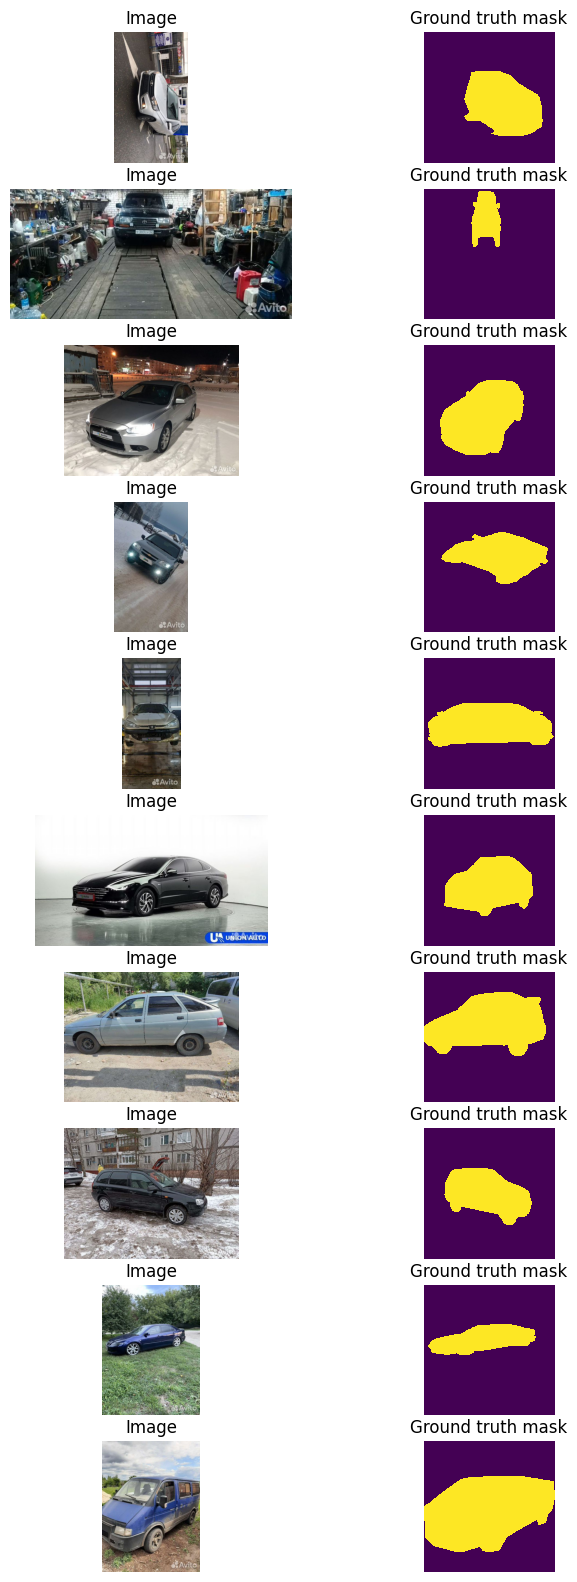

In [ ]:
sample = annot.sample(10, random_state=42)
plot_samples(sample['image'], sample['mask'], nrows=10)

In [ ]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

train_transforms = A.Compose([
    
    #A.CropAndPad(percent=0.05, p=0.5),
    A.Resize(224, 224),
    
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.5),
    A.Normalize(MEAN, STD),
    ToTensorV2(), 
  ],  
  additional_targets={'image1': 'mask'})


val_transforms = A.Compose([
    A.Resize(224, 224),
    
    A.Normalize(MEAN, STD),
    ToTensorV2(),
])


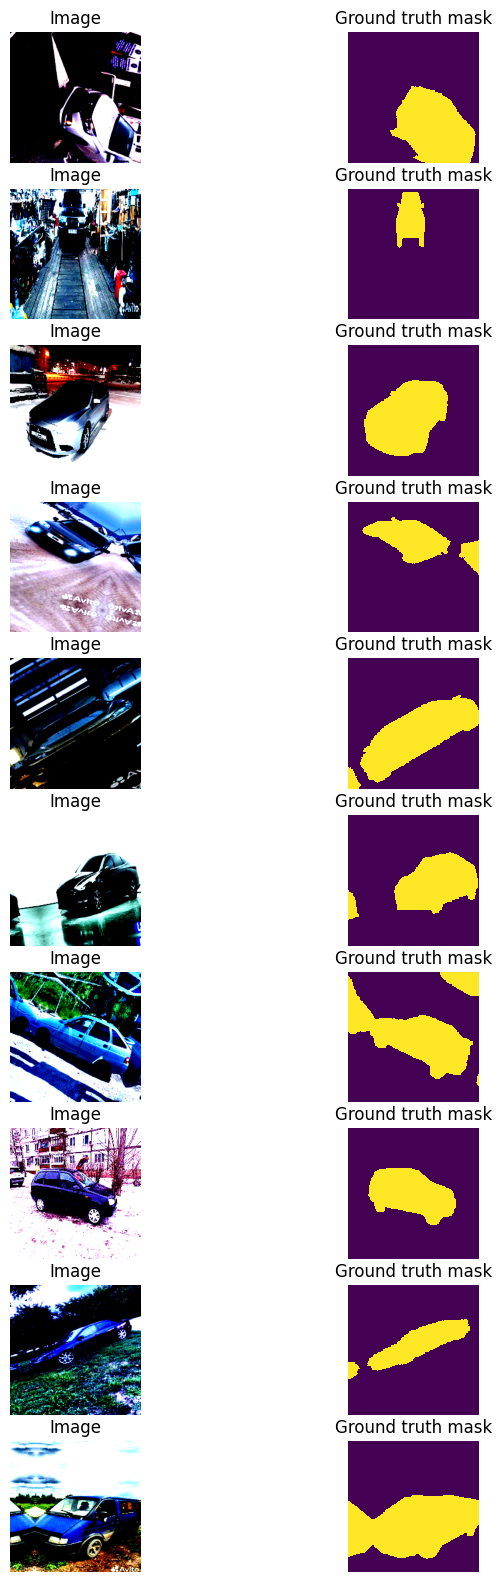

In [ ]:
sample = annot.sample(10, random_state=42)
plot_samples(sample['image'], sample['mask'], nrows=10, transforms=train_transforms)

In [ ]:
class ImageDataset(Dataset):
    
    def __init__(self, images, masks, transforms):
        
        super(ImageDataset).__init__()
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
       
        image = plt.imread(self.images[index])
        mask = plt.imread(self.masks[index])
        transformed = self.transforms(image=image, mask=mask)
        return transformed['image'], (transformed['mask']*255).int()[None, :, :]

In [ ]:
train_images,rest_images, train_masks, rest_masks = train_test_split(annot['image'].values,
                                                                    annot['mask'].values,
                                                                    random_state=42, train_size=0.8)
val_images,test_images, val_masks, test_masks = train_test_split(rest_images,
                                                                 rest_masks,
                                                                 random_state=42, test_size=0.5)

train_dataset = ImageDataset(train_images, train_masks, train_transforms)
val_dataset = ImageDataset(val_images, val_masks, val_transforms)
test_dataset = ImageDataset(test_images, test_masks, val_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = smp.DeepLabV3Plus("resnet34", encoder_weights="imagenet", classes=1)
model = model.to(DEVICE)

In [ ]:
def plot_progress(train_losses, train_iou, test_loss, test_iou):
    clear_output(True)
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(6)
    f.set_figwidth(18)
    
    ax1.plot(train_losses, label='train loss')
    ax1.plot(test_loss, label='test loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    
#     Для ограничения графика loss можно пользоваться set_ylim:
    ax1.set_ylim([-0.05, 0.5])

    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch number')
    ax1.legend()
    
    ax2.plot(train_iou, label='train iou')
    ax2.plot(test_iou, label='test iou')
    ax2.set_title('IoU')
    ax2.set_ylabel('IoU')
    ax2.set_xlabel('Epoch number')
    ax2.legend()

    plt.show()

In [ ]:
torch.cuda.empty_cache()
import gc

gc.collect()

96331

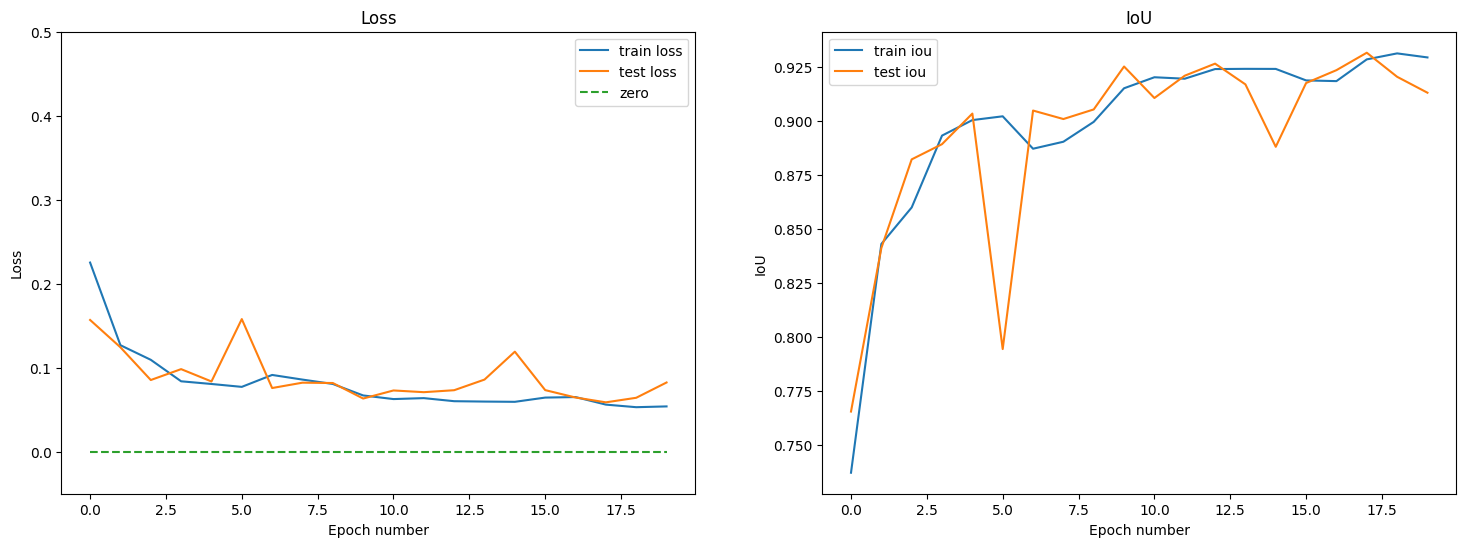

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = torch.nn.BCEWithLogitsLoss()

n_epochs = 20

train_losses = []
train_iou = []

val_losses = []
val_iou = []


best_loss = float('inf')

for epoch in tqdm(range(n_epochs)):
    
    train_loss_agg = []
    train_iou_agg = []
    
    for data_train, target_train in tqdm(train_dataloader):
        
        model.train()
        
        data_train = data_train.to(DEVICE)
        target_train = target_train.to(DEVICE)
        
        optimizer.zero_grad()

        train_preds = model(data_train)
        
        train_loss = criterion(train_preds, target_train.float())

        tp, fp, fn, tn = smp.metrics.get_stats(train_preds, target_train, mode='multilabel', threshold=0.5)
        train_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
        train_loss_agg.append(train_loss.item())
        train_iou_agg.append(train_iou_score)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
        
    train_epoch_loss = sum(train_loss_agg) / len(train_loss_agg)
    train_epoch_iou = sum(train_iou_agg) / len(train_iou_agg)
    
    train_losses.append(train_epoch_loss)
    train_iou.append(train_epoch_iou.cpu())
    
    model.eval() 
    
    val_loss_agg = []
    val_iou_agg = []
    
    for x_val, y_val in tqdm(val_dataloader):      
        
        x_val = x_val.to(DEVICE)
        y_val = y_val.to(DEVICE)
        
        with torch.no_grad():
            val_preds = model(x_val)
            val_loss = criterion(val_preds, y_val.float())

            tp, fp, fn, tn = smp.metrics.get_stats(val_preds, y_val, mode='multilabel', threshold=0.5)
            val_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

            val_loss_agg.append(val_loss.item())
            val_iou_agg.append(val_iou_score.cpu())
    
    val_epoch_loss = sum(val_loss_agg) / len(val_loss_agg)
    val_epoch_iou = sum(val_iou_agg) / len(val_iou_agg)
    
    val_losses.append(val_epoch_loss)
    val_iou.append(val_epoch_iou)
    
    if val_epoch_loss < best_loss:
        best_loss = val_epoch_loss
        torch.save(model.state_dict(), f'model_best_loss_{epoch}_{val_epoch_loss:.4f}.pt')
    

    plot_progress(train_losses, train_iou, val_losses, val_iou)

In [ ]:
train_losses, train_iou, val_losses, val_iou

([0.22519388948293292,
  0.12679968664751334,
  0.10942133340765448,
  0.08384458775467732,
  0.08064515132676153,
  0.07720313736182802,
  0.09139997983241782,
  0.08586952408008716,
  0.08066529682015672,
  0.06698910672875012,
  0.06267320682459018,
  0.06380868944175103,
  0.06014964006402913,
  0.059701844173319196,
  0.059406157473430914,
  0.06444406114956912,
  0.06507888206225984,
  0.05607678324860685,
  0.05301130398669664,
  0.053940740578314834],
 [tensor(0.7372),
  tensor(0.8430),
  tensor(0.8599),
  tensor(0.8932),
  tensor(0.9003),
  tensor(0.9021),
  tensor(0.8871),
  tensor(0.8903),
  tensor(0.8995),
  tensor(0.9150),
  tensor(0.9201),
  tensor(0.9195),
  tensor(0.9239),
  tensor(0.9240),
  tensor(0.9240),
  tensor(0.9187),
  tensor(0.9184),
  tensor(0.9284),
  tensor(0.9312),
  tensor(0.9293)],
 [0.15685313642024995,
  0.12429845780134201,
  0.08535579368472099,
  0.09832434728741646,
  0.08364092111587525,
  0.15789976865053176,
  0.07582466006278991,
  0.0821945853

In [ ]:
model.load_state_dict(torch.load('/content/model_best_loss_17_0.0588.pt')) # or '/content/model_best_loss_10_0.0586.pt'
model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

### ! Очень важно ещё посмотреть на IOU для других tredshold!=0.5

In [ ]:
def best_treshold_iou(dataloader):

  stats_df = pd.DataFrame()
  loss_agg = []
  iou_agg = []


  d = {}

  for x_train, y_train in tqdm(dataloader):      
          
          x_train = x_train.to(DEVICE)
          y_train = y_train.to(DEVICE)
          
          with torch.no_grad():
              preds = model(x_train)
              loss = criterion(preds, y_train.float())

              for TRESHOLD_VAL in np.linspace(0.01, 0.5, 50):
                tp, fp, fn, tn = smp.metrics.get_stats(preds, y_train, mode='multilabel', threshold=TRESHOLD_VAL)
                iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

                TRESHOLD = np.round(TRESHOLD_VAL,2)
                if TRESHOLD not in d:
                  d[TRESHOLD] = iou_score.cpu().numpy()
                else:
                  d[TRESHOLD] +=   iou_score.cpu().numpy()

              loss_agg.append(loss.item())
              iou_agg.append(iou_score.cpu())
  
  stats_df = pd.DataFrame.from_dict(d, orient='index')

  print(iou_agg)
  print(len(iou_agg))
  return stats_df / len(dataloader)

In [ ]:
stats = best_treshold_iou(val_dataloader)

stats

  0%|          | 0/5 [00:00<?, ?it/s]

[tensor(0.9400), tensor(0.9470), tensor(0.9419), tensor(0.9399), tensor(0.8886)]
5


0
0.01  0.934027
0.02  0.934002
0.03  0.934000
0.04  0.933992
0.05  0.933959
0.06  0.933951
0.07  0.933950
0.08  0.933912
0.09  0.933907
0.10  0.933875
0.11  0.933865
0.12  0.933832
0.13  0.933840
0.14  0.933816
0.15  0.933754
0.16  0.933721
0.17  0.933698
0.18  0.933681
0.19  0.933644
0.20  0.933605
0.21  0.933549
0.22  0.933476
0.23  0.933395
0.24  0.933348
0.25  0.933275
0.26  0.933241
0.27  0.933197
0.28  0.933149
0.29  0.933083
0.30  0.932995
0.31  0.932909
0.32  0.932843
0.33  0.932787
0.34  0.932688
0.35  0.932642
0.36  0.932572
0.37  0.932483
0.38  0.932436
0.39  0.932356
0.40  0.932268
0.41  0.932216
0.42  0.932148
0.43  0.932068
0.44  0.932007
0.45  0.931936
0.46  0.931841
0.47  0.931739
0.48  0.931645
0.49  0.931567
0.50  0.931485

In [ ]:
best = stats.sort_values(by=[0], ascending=False).iloc[0]
print(f'Best treshold = {best.name}, iou_valid_val= {best.values[0]}')
BEST_TRESHOLD = best.name

Best treshold = 0.01, iou_valid_val= 0.9340265393257141


### Test metrics:  

In [ ]:
test_loss_agg = []
test_iou_agg = []

for x_test, y_test in tqdm(test_dataloader):      
        
        x_test = x_test.to(DEVICE)
        y_test = y_test.to(DEVICE)
        
        with torch.no_grad():
            test_preds = model(x_test)
            test_loss = criterion(test_preds, y_test.float())

            tp, fp, fn, tn = smp.metrics.get_stats(test_preds, y_test, mode='multilabel', threshold=BEST_TRESHOLD)
            test_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

            test_loss_agg.append(test_loss.item())
            test_iou_agg.append(test_iou_score.cpu())
    
test_loss = sum(test_loss_agg) / len(test_loss_agg)
test_iou = sum(test_iou_agg) / len(test_iou_agg)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
print(f'test_loss= {test_loss} test_iou= {test_iou}')

test_loss= 0.05060710683465004 test_iou= 0.9343794584274292


In [ ]:
annot

image                        mask
0     auto-10k/16755467472.jpg  masks/16755467472_mask.png
1     auto-10k/16439693736.jpg  masks/16439693736_mask.png
2     auto-10k/16468755290.jpg  masks/16468755290_mask.png
3     auto-10k/16676029209.jpg  masks/16676029209_mask.png
4     auto-10k/16075846012.jpg  masks/16075846012_mask.png
...                        ...                         ...
1333  auto-10k/16782630689.jpg  masks/16782630689_mask.png
1334  auto-10k/16760959802.jpg  masks/16760959802_mask.png
1335  auto-10k/16536055602.jpg  masks/16536055602_mask.png
1336  auto-10k/13582227789.jpg  masks/13582227789_mask.png
1337  auto-10k/16524679535.jpg  masks/16524679535_mask.png

[1338 rows x 2 columns]

In [ ]:
def get_pred(model):
  batch = next(iter(test_dataloader))
  with torch.no_grad():
      model.eval()
      logits = model(batch[0].to(DEVICE))
  pr_masks = logits.sigmoid()

### Visualizations of first test batch: 

In [ ]:
BATCH_SIZE

32

In [ ]:
%time get_pred(model)

CPU times: user 384 ms, sys: 19.8 ms, total: 404 ms
Wall time: 496 ms


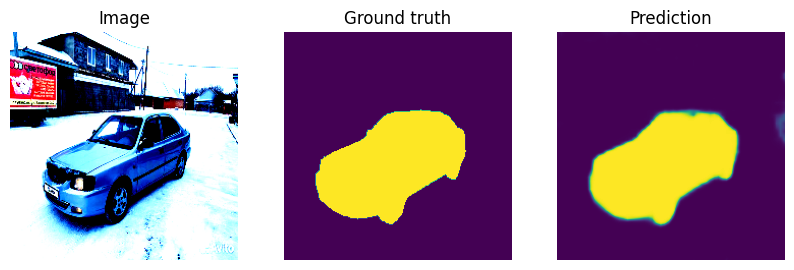

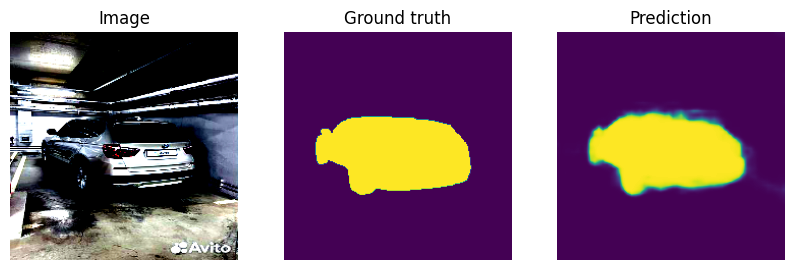

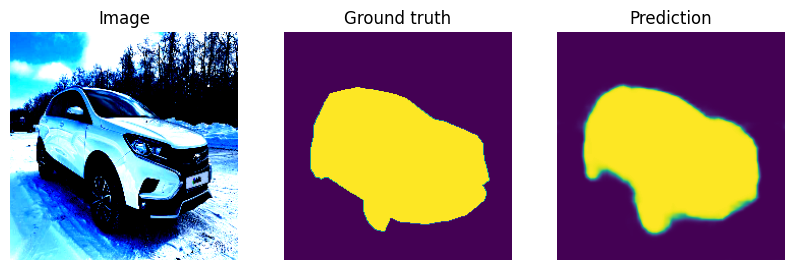

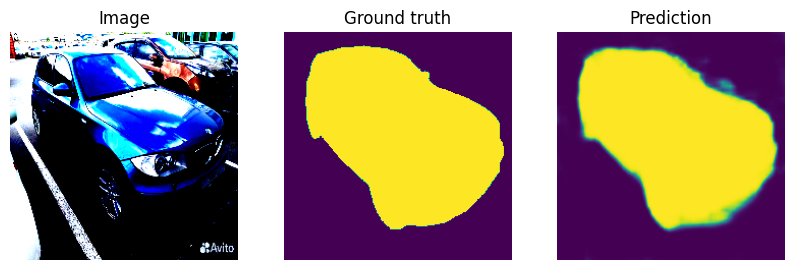

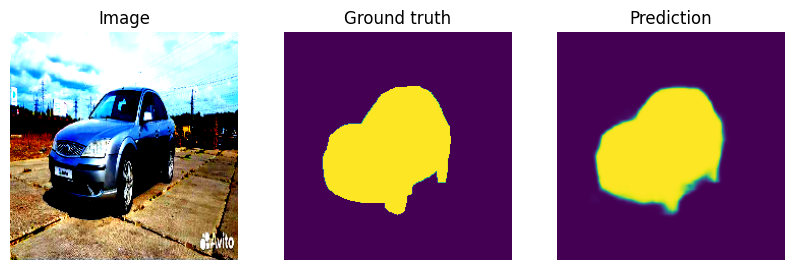

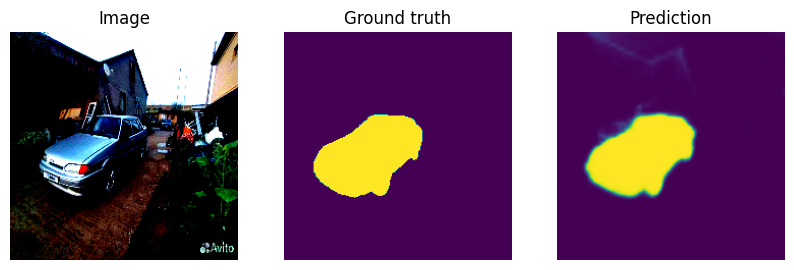

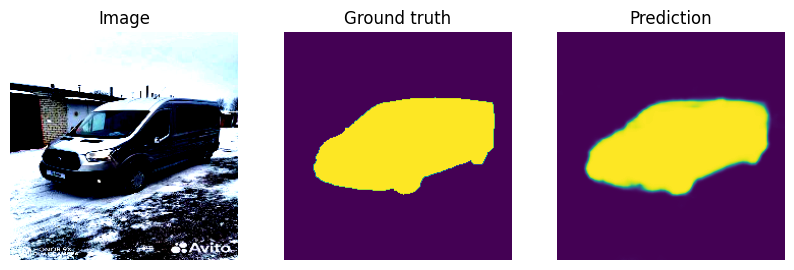

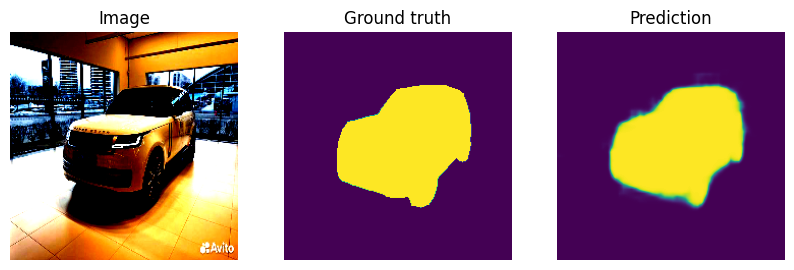

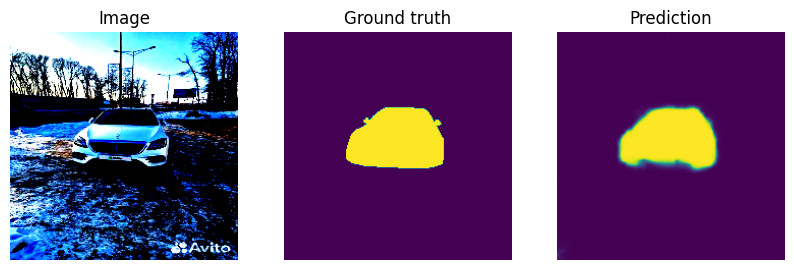

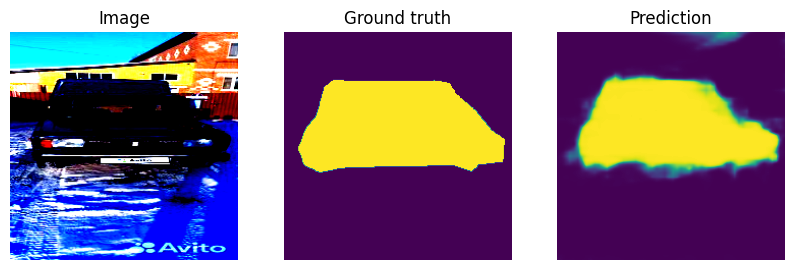

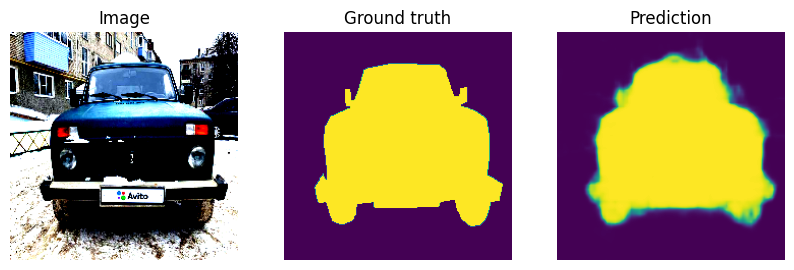

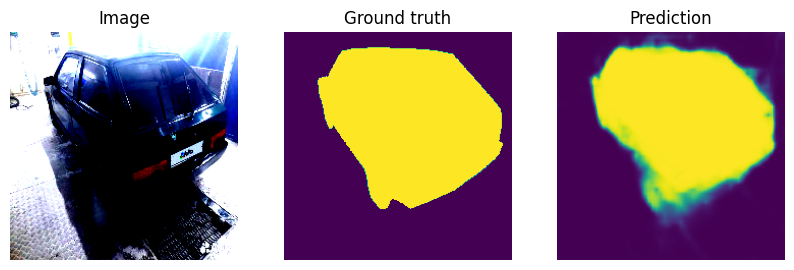

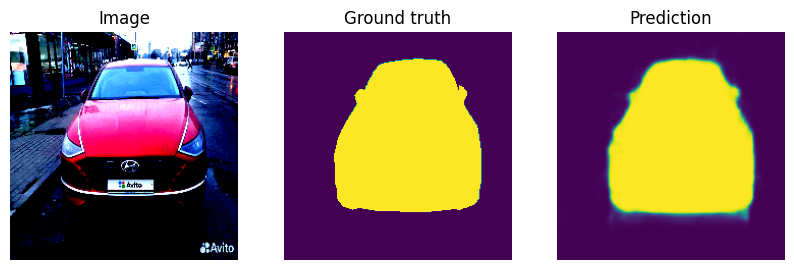

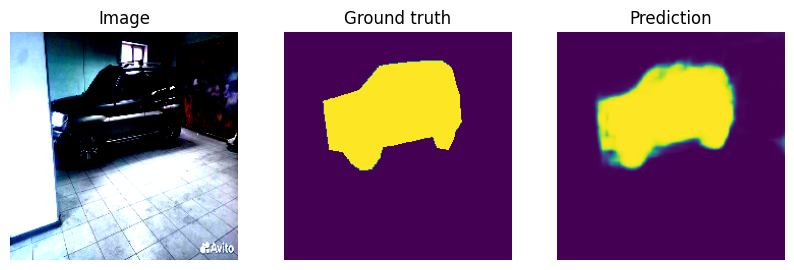

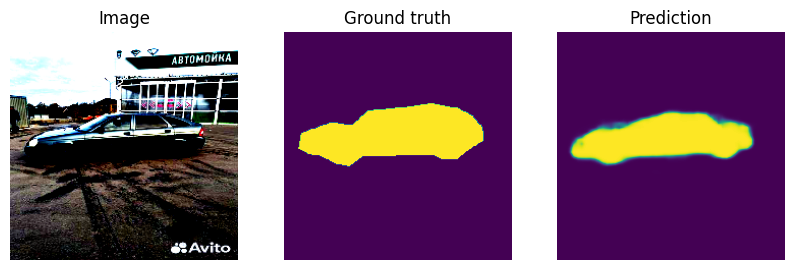

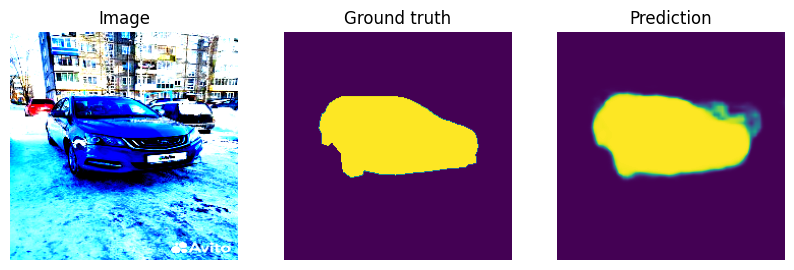

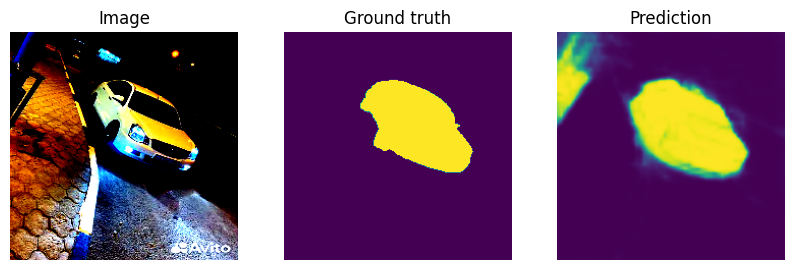

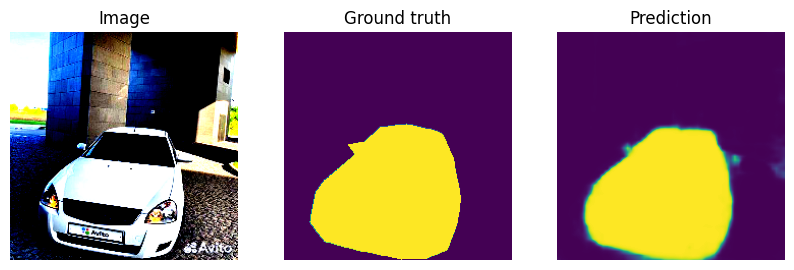

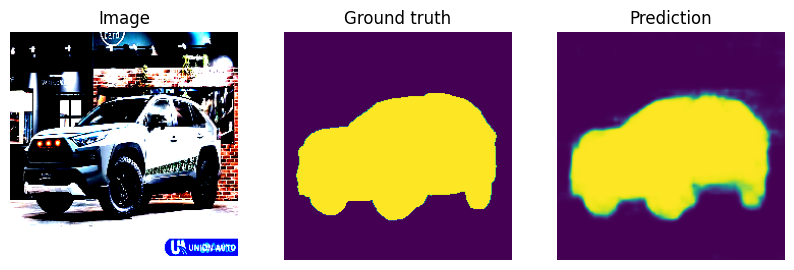

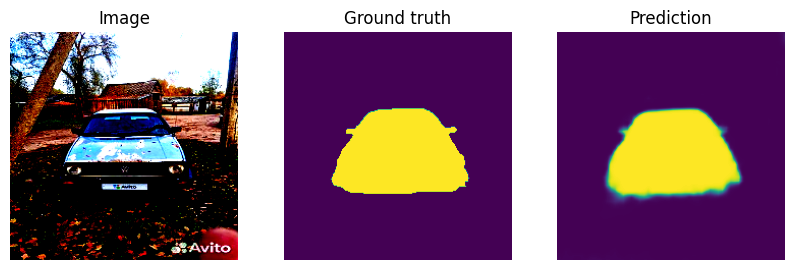

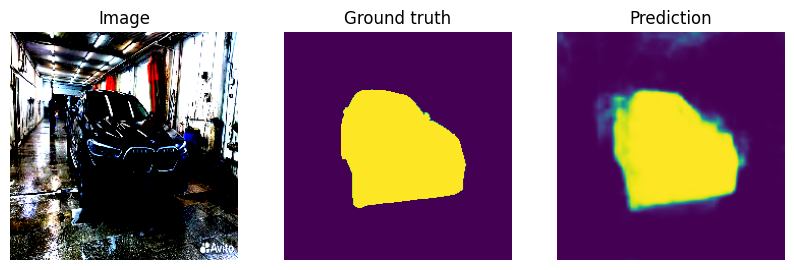

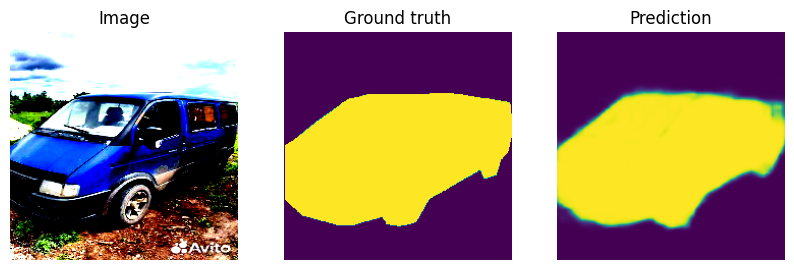

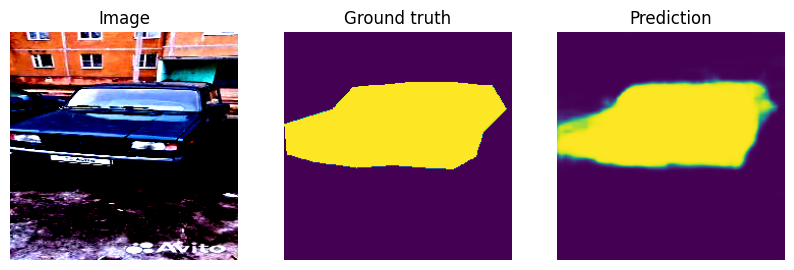

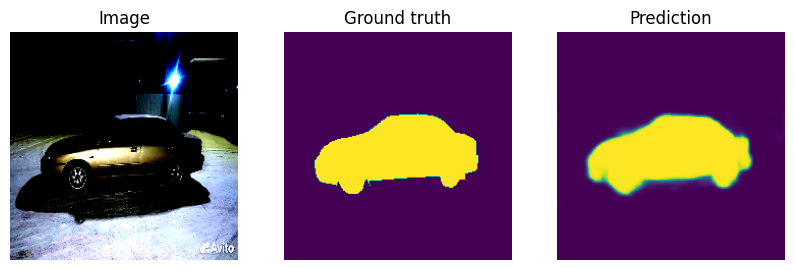

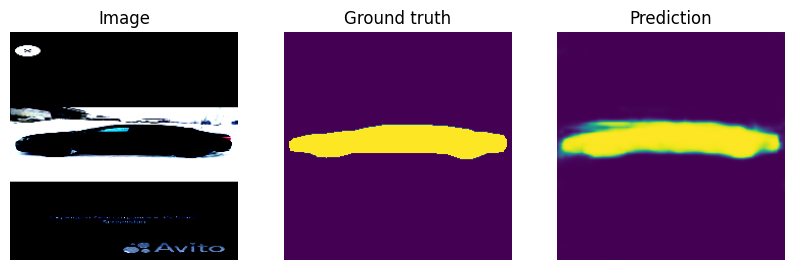

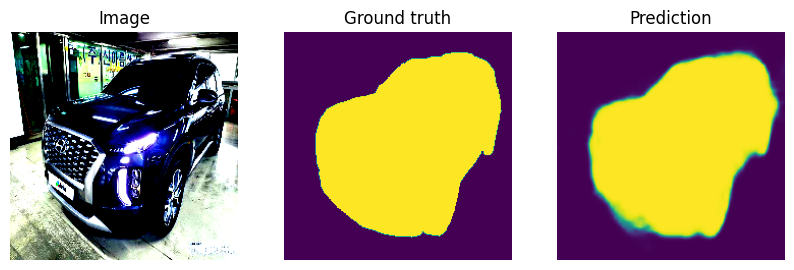

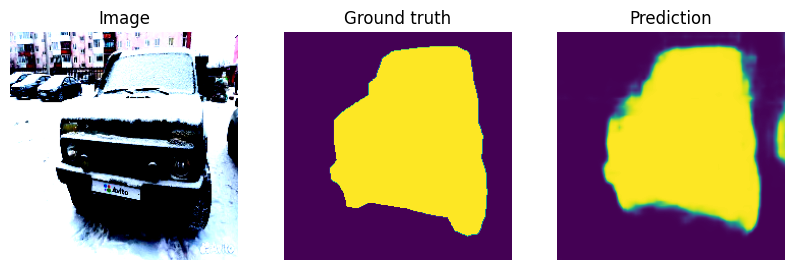

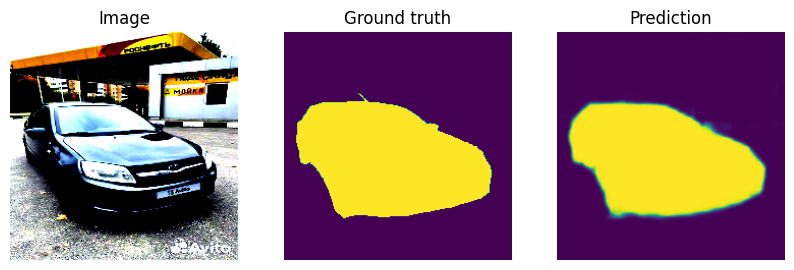

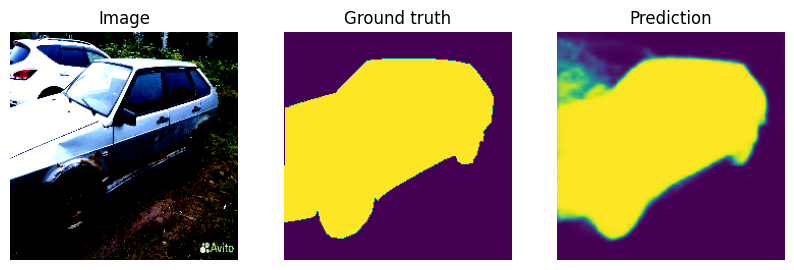

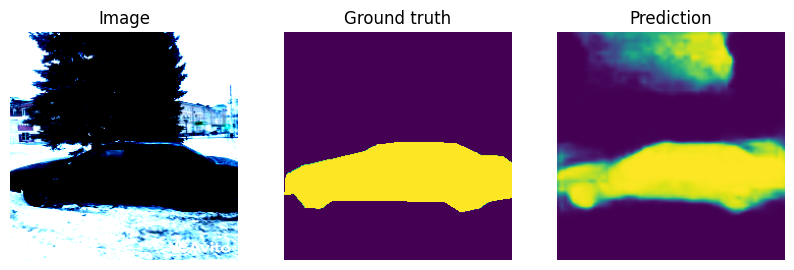

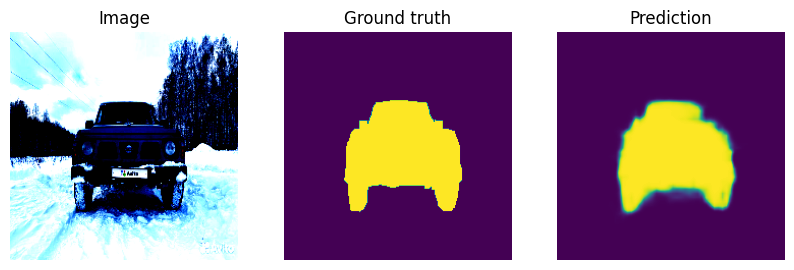

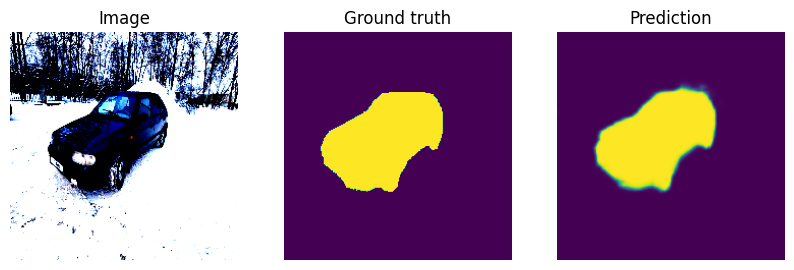

In [ ]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(DEVICE))
pr_masks = logits.sigmoid()
for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.cpu().numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.cpu().numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.cpu().numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

### Efficientnetb0: 2min/epoch training; 30sec test
### Resnet-like: 11-14 sec training; <=5sec test 

### ! Похоже, что где-то теряется детерменируемость (но могу ошибаться)

In [ ]:
# для efficientnet encoder_weights="noisy_student"

In [ ]:
#Нет указаний по параметрам -> всё так же, как и на исходном ноутбуке

d = {'model+params':['deeplab++resnet34','deeplab++resnet18','deeplab++resnet18+blur','deeplab++resnet18+CropAndPad(percent=0.05)+default shift+blur','deeplab++_prev_config+timm-efficientnet-b0','deeplab++blur+timm-efficientnet-b0','PSPNet+resnet18+blur'],
     'best_test_loss': [0.0634,0.599, 0.0602, '-', 0.0525,0.0510,0.0891], 'valid_iou': [0.9223, 0.9274, 0.9305, '-', 0.9158, 0.9374,0.8856],
     'test_iou':[0.9250, 0.9285, 0.9329, '-', 0.9344, 0.9412,0.8922],'best_treshold_iou':['-','-','-','-','0.93558(0.15)','0.94442(0.25)','0.9018(0.01)']}

df = pd.DataFrame(data=d)

df

model+params best_test_loss valid_iou  \
0                                  deeplab++resnet34         0.0634    0.9223   
1                                  deeplab++resnet18          0.599    0.9274   
2                             deeplab++resnet18+blur         0.0602    0.9305   
3  deeplab++resnet18+CropAndPad(percent=0.05)+def...              -         -   
4         deeplab++_prev_config+timm-efficientnet-b0         0.0525    0.9158   
5                 deeplab++blur+timm-efficientnet-b0          0.051    0.9374   
6                               PSPNet+resnet18+blur         0.0891    0.8856   

  test_iou best_treshold_iou  
0    0.925                 -  
1   0.9285                 -  
2   0.9329                 -  
3        -                 -  
4   0.9344     0.93558(0.15)  
5   0.9412     0.94442(0.25)  
6   0.8922      0.9018(0.01)